In [ ]:
!pip install openai
!pip install typing_extensions

In [ ]:
import pandas as pd
import numpy as np
from openai import OpenAI
from tqdm import tqdm
import json

In [ ]:
data=pd.read_csv("./substance_interactions_cleaned.csv")
data=data.iloc[:,1:]
data.reset_index(drop=True, inplace=True)
data.head(15)

,id,sentence1,sentence2,label,split
0,P5444,conversion of 3-nitrotyrosine to 3-aminotyrosi...,3-nitrotyrosine interacts with 3-aminotyrosine,0,train
1,P3398,interaction of myeloperoxidase with diclofenac.,diclofenac interacts with myeloperoxidase,1,train
2,P3609,"in these eight pairs, an increase in n-methyl-...",nmda interacts with glutamate,0,train
3,P4925,forced overexpression of ssi-1 complementary d...,lif interacts with stat3,0,train
4,P4940,"ciz1 bound to the n-terminal, the cdk2-interac...",p21 inhibits cdk2,0,train
5,P4683,the cellular processes mediated by the interac...,cs1 peptide inhibits fn,0,train
6,P3196,the antibacterial agent fludalanine [2-2h-3-fl...,alanine inhibits alanine racemase,0,train
7,P5803,influence of ribonucleotides on the utilizatio...,deoxyribonucleotides interacts with ribonucleo...,1,train
8,P5805,[in vitro effect of spiramycin on 153 strains ...,spiramycin interacts with erythromycin,0,train
9,P3805,exposure of f0 subunits in inverted and right-...,proteases interacts with antibody,0,train


# Preparing training and test files according to the standard of OpenAI API

In [ ]:
# Splitting the data into training, validation, and test sets (600, 600, 2200)
train_data = data[data['split'] == 'test'].sample(n=600, random_state=42)
valid_data = data[data['split'] == 'dev'].sample(n=600, random_state=43)
test_data = data[data['split'] == 'train'].sample(n=1800, random_state=44)

# Function to create a JSON line from a row of data
def create_json_line(row):
    user_message = {
        "role": "user",
        "content": f"sentence1: {row['sentence1']}\nsentence2: {row['sentence2']}\nquestion: Is sentence2 asserted by sentence1 ?"
    }
    assistant_message = {
        "role": "assistant",
        "content": str(int(row['label'] == 1))
    }
    return json.dumps({"messages": [user_message, assistant_message]})


with open("train.jsonl", "w") as train_file:
    for _, row in train_data.iterrows():
        train_file.write(create_json_line(row) + "\n")

with open("valid.jsonl", "w") as valid_file:
    for _, row in valid_data.iterrows():
        valid_file.write(create_json_line(row) + "\n")

with open("test.jsonl", "w") as test_file:
    for _, row in test_data.iterrows():
        test_file.write(create_json_line(row) + "\n")

# **Upload dataset for finetuning**

In [ ]:
client = OpenAI(api_key='<API_KEY>')

client.files.create(
  file=open("train.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-2K20GV15rnEkOCw9XtKhZICK', bytes=219349, created_at=1706582019, filename='train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

# **Finetuning the GPT 3.5 Turbo model**

In [ ]:
train_file = client.files.create(file=open("train.jsonl", "rb"), purpose="fine-tune")
valid_file = client.files.create(file=open("valid.jsonl", "rb"), purpose="fine-tune")

fine_tuning_job = client.fine_tuning.jobs.create(training_file=train_file.id, validation_file=valid_file.id, model="gpt-3.5-turbo")

print(fine_tuning_job)


FineTuningJob(id='ftjob-RT5sFrz2xysMKLA0hdWXjoC9', created_at=1706584445, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-UxQiOxSHY3AAvWou6Xcd4EHi', result_files=[], status='validating_files', trained_tokens=None, training_file='file-M5FUMhvYyHzN7JvyH5cDYnyP', validation_file='file-aC5IwkMdUBymkl4vUo9ifRkj')


In [ ]:
fine_tune_results = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
print(fine_tune_results.finished_at)

1706588065


In [ ]:
fine_tune_results = client.fine_tuning.jobs.retrieve(fine_tuning_job.id).result_files
result_file = client.files.retrieve(fine_tune_results[0])
content = client.files.content(result_file.id)
# saving content to file
with open("result.csv", "wb") as f:
    f.write(content.text.encode("utf-8"))

In [ ]:
results = pd.read_csv('result.csv')
results[results['train_accuracy'].notnull()].tail(1)

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
1799,1800,0.0,1.0,NaN,NaN


<Axes: >

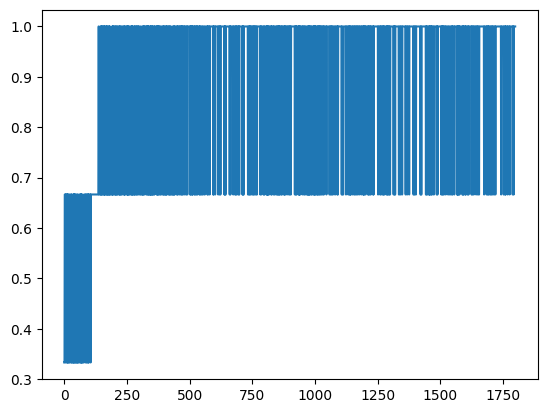

In [ ]:
results[results['train_accuracy'].notnull()]['train_accuracy'].plot()

# **Preparing Test file**

In [ ]:
# getting a single response
response = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0613:personal::8mZnutuV",
  messages=[{'role': 'user', 'content': 'sentence1: the leu68 side-chain can rotate about its c alpha-c beta and c beta-c gamma bonds to better accommodate bound ligands, resulting in net increases in overall association rate constants and affinities due to the absence of the distal pocket water molecule.\nsentence2: water stimulates net\nquestion: Is sentence2 asserted by sentence1 ?'}]
)
print(response.choices[0].message.content[0],test_data[0]["messages"][-1]["content"])

0 0


In [ ]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

data = load_jsonl('test.jsonl')

In [ ]:
formatted_data = [{'messages': [{'role': 'user', 'content': message['content']} for message in sample['messages']]} for sample in data]

with open('test2.jsonl', 'w') as jsonl_file:
    for sample in formatted_data:
        json.dump(sample, jsonl_file)
        jsonl_file.write('\n')

In [ ]:
def calculate_accuracy(model_responses, test_data):
    correct_predictions = 0
    total_samples = len(test_data)

    for i, sample in enumerate(test_data):
        model_response = int(model_responses[i].strip())
        true_label = int(sample['messages'][-1]['content'].strip())
        if model_response == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / total_samples
    return accuracy

In [ ]:
client = OpenAI(api_key='<API_KEY>')
test_data = []
with open('test2.jsonl', 'r') as jsonl_file:
    for line in jsonl_file:
        test_data.append(json.loads(line))

# Defining a function to make API requests and get responses
def get_responses(model,data):
    responses = []
    for sample in tqdm(data):
        # print(sample)
        # for message in sample["messages"]:
        message=sample["messages"][0]
        # print(message)
        response = client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0613:personal::8mZnutuV",  # Replace with your fine-tuned model name
            messages=[message],
            max_tokens=1, temperature=0
        )
        # print("model_response=",response.choices[0].message.content[0])
        # print("true_label=", sample["messages"][-1])
        responses.append(response.choices[0].message.content[0])
    return responses


ft_model = "ft:gpt-3.5-turbo-0613:personal::8mZnutuV"
model_responses = get_responses(ft_model,test_data)
print(model_responses)
acc= calculate_accuracy(model_responses, test_data)
print(acc)

100%|██████████| 1800/1800 [06:01<00:00,  4.98it/s]

['0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1',

# **Results**

In [ ]:
for i in range(len(model_responses)):
    if model_responses[i]==test_data[i]["messages"][-1]["content"]:
        print(f'\033[92mModel Response= {model_responses[i]==str(1)}, Actual Label= {test_data[i]["messages"][-1]["content"]==str(1)}\033[0m')
    else:
        print(f'\033[91mModel Response= {model_responses[i]==str(1)}, Actual Label= {test_data[i]["messages"][-1]["content"]==str(1)}\033[0m')

Model Response= False, Actual Label= False
Model Response= False, Actual Label= False
Model Response= True, Actual Label= True
Model Response= True, Actual Label= True
Model Response= True, Actual Label= False
Model Response= False, Actual Label= False
Model Response= False, Actual Label= True
Model Response= False, Actual Label= False
Model Response= True, Actual Label= False
Model Response= False, Actual Label= False
Model Response= True, Actual Label= True
Model Response= True, Actual Label= True
Model Response= False, Actual Label= False
Model Response= False, Actual Label= False
Model Response= True, Actual Label= True
Model Response= True, Actual Label= True
Model Response= True, Actual Label= True
Model Response= True, Actual Label= True
Model Response= False, Actual Label= True
Model Response= False, Actual Label= False
Model Response= True, Actual Label= True
Model Response= True, Actual Label= True
Model Response= False, Actual Label= False
Model Response= True, Actual Label=



---


# **Hence, we have only trained the model with 600 samples. but got the best result among all the models.**


---

